In [2]:
import sys
sys.path.append('..')

import os

import pickle as pkl
from pid.rus import *
from pid.utils import clustering

from dit.pid import iwedge
from dit import Distribution
from dit.shannon import mutual_information

from matplotlib import pyplot as plt

In [3]:
def reshape_list(input_list):
    n_reps = 3
    n_blocks = len(input_list) // n_reps

    reps = []
    for i in range(n_reps):
        a = []
        for j in range(n_blocks):
            a.extend(input_list[j*n_reps + i])
        
        reps.append(a)
    return reps

In [4]:
def fetch_reps(idx, reps_dir):
    reps_file = open(f'{reps_dir}/reps_{idx}', 'rb')
    t_reps = pkl.load(reps_file)
    s_reps = pkl.load(reps_file)
    labels = pkl.load(reps_file)
    reps_file.close()

    t_reps = reshape_list(t_reps)
    s_reps = reshape_list(s_reps)
    return t_reps, s_reps, np.array(labels)

In [5]:
def compute_measures(rep_i, t_reps, s_reps, labels):
    t_disc, _ = clustering(np.reshape(t_reps[rep_i], (len(t_reps[rep_i]),-1)), pca=True, n_components=5, n_clusters=10)
    s_disc, _ = clustering(np.reshape(s_reps[rep_i], (len(s_reps[rep_i]),-1)), pca=True, n_components=5, n_clusters=10)
    print(f'Clustering complete. t_disc shape:{t_disc.shape}, s_disc shape:{s_disc.shape}')
    distrib_tsy, maps = convert_data_to_distribution(t_disc, s_disc, labels)

    print(f'distribution t,s,y shape:{distrib_tsy.shape}')
    dit_distrib_tsy = Distribution.from_ndarray(distrib_tsy)

    return get_measure(distrib_tsy)

In [6]:
# %%capture
# # compute PID values

# reps_dir = './representations_red_ut'
# meas_dir = './measures_red_ut'

# if os.path.exists(meas_dir) and os.path.isdir(meas_dir):
#     raise FileExistsError(f"Error: The folder '{meas_dir}' already exists.")
# else:
#     os.makedirs(meas_dir)
#     print(f'created directory {meas_dir}')

# for rep_i in range(3):
#     for i in range(0,250,20):
#         print(f'rep_i={rep_i}, i={i}')
#         t_reps, s_reps, labels = fetch_reps(i, reps_dir)
#         measures = compute_measures(rep_i, t_reps, s_reps, labels)
        
#         filename = f'{meas_dir}/reps_{rep_i}_{i}'
#         with open(filename, 'wb') as file:
#             pkl.dump(measures, file)


In [7]:

def fetch_measures(dir, epochs, measure):
    measures = {}
    for rep_i in range(3):
        measure_list = []
        for i in epochs:
            filename = f'{dir}/reps_{rep_i}_{i}'
            with open(filename, 'rb') as file:
                measure_dict = pkl.load(file)
                measure_list.append(measure_dict[measure])
        measures[rep_i] = measure_list

    return measures

In [8]:
def add_measures(meas_1, meas_2):
    reps = meas_1.keys()
    n_reps = len(reps)
    sum = {}
    for i in range(n_reps):
        sub_total = []
        for j in range(len(meas_1[i])):
            sub_total.append(meas_1[i][j] + meas_2[i][j])
        sum[i] = sub_total

    return sum


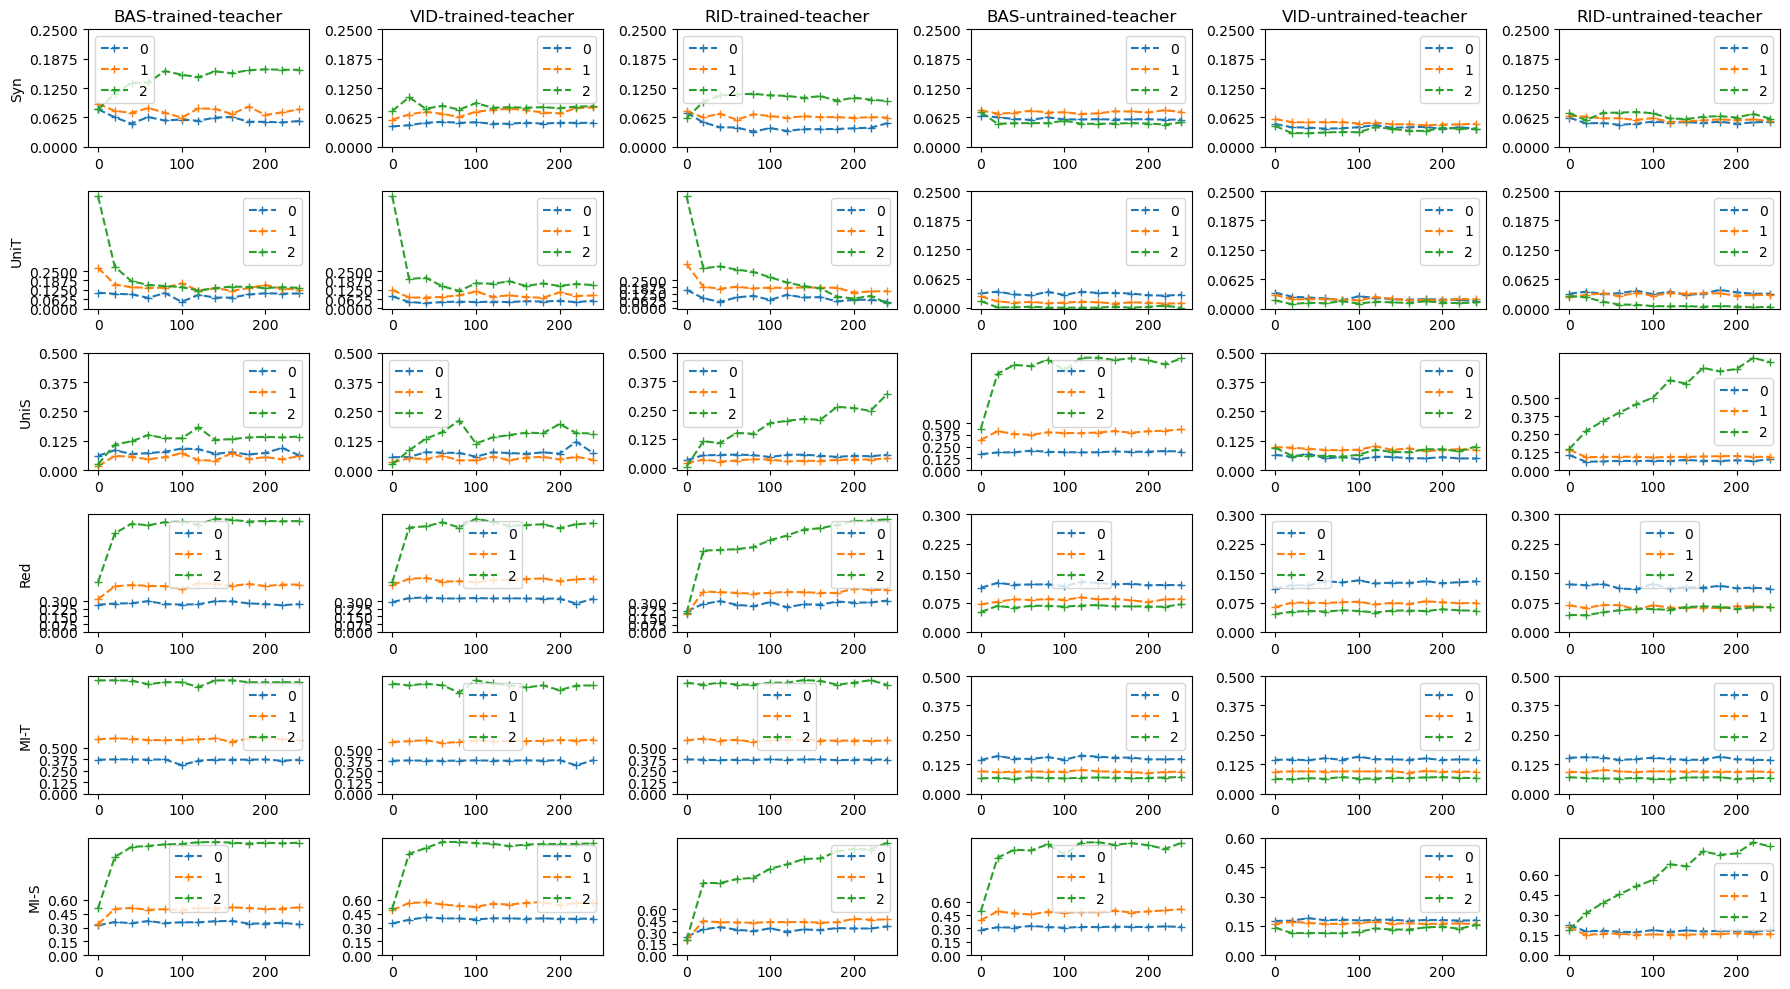

In [9]:
# Example list of folders (replace with your actual list)
folders = [
    './meas/meas_bas_tt', 
    './meas/meas_vid_tt', 
    './meas/meas_red_tt',
    # './meas/meas_ted_tt', 
    './meas/meas_bas_ut',
    './meas/meas_vid_ut', 
    './meas/meas_red_ut',
    # './meas/meas_ted_ut',
]
titles = [
    'BAS-trained-teacher',
    'VID-trained-teacher',
    'RID-trained-teacher',
    # 'TED-trained-teacher',
    'BAS-untrained-teacher',
    'VID-untrained-teacher',
    'RID-untrained-teacher',
    # 'TED-untrained-teacher',
]
n_reps = 3
epochs = np.arange(0,250,20)


y_ticks = [
    np.linspace(0, 0.25, 5),
    np.linspace(0, 0.25, 5),
    np.linspace(0, 0.5, 5),
    np.linspace(0, 0.3, 5),
    np.linspace(0, 0.5, 5),
    np.linspace(0, 0.6, 5),
]

# Calculate the grid size
N = len(folders)
rows = 6
cols = N

# Create a grid of subplots
fig, axes = plt.subplots(rows, cols, figsize=(3*N, 10))
# axes = axes.flatten()  # Flatten the axes array to easily iterate over

for j, folder in enumerate(folders):
    syn = fetch_measures(folder, epochs, 'syn')
    uniT = fetch_measures(folder, epochs, 'uni1')
    uniS = fetch_measures(folder, epochs, 'uni2')
    red = fetch_measures(folder, epochs, 'red')
    miT = add_measures(uniT, red)
    miS = add_measures(uniS, red)
    measures_list = [syn, uniT, uniS, red, miT, miS]
    measure_names = ['Syn', 'UniT', 'UniS', 'Red', 'MI-T', 'MI-S']
    for i in range(len(measures_list)):
        axes[i, 0].set_ylabel(measure_names[i])
        for rep_i in range(n_reps):
            axes[i, j].plot(epochs, measures_list[i][rep_i], '--+', label=rep_i)
            axes[i, j].set_yticks(y_ticks[i])
            axes[i, j].legend()

    axes[0, j].set_title(f"{titles[j]}")    

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


## Other Plots

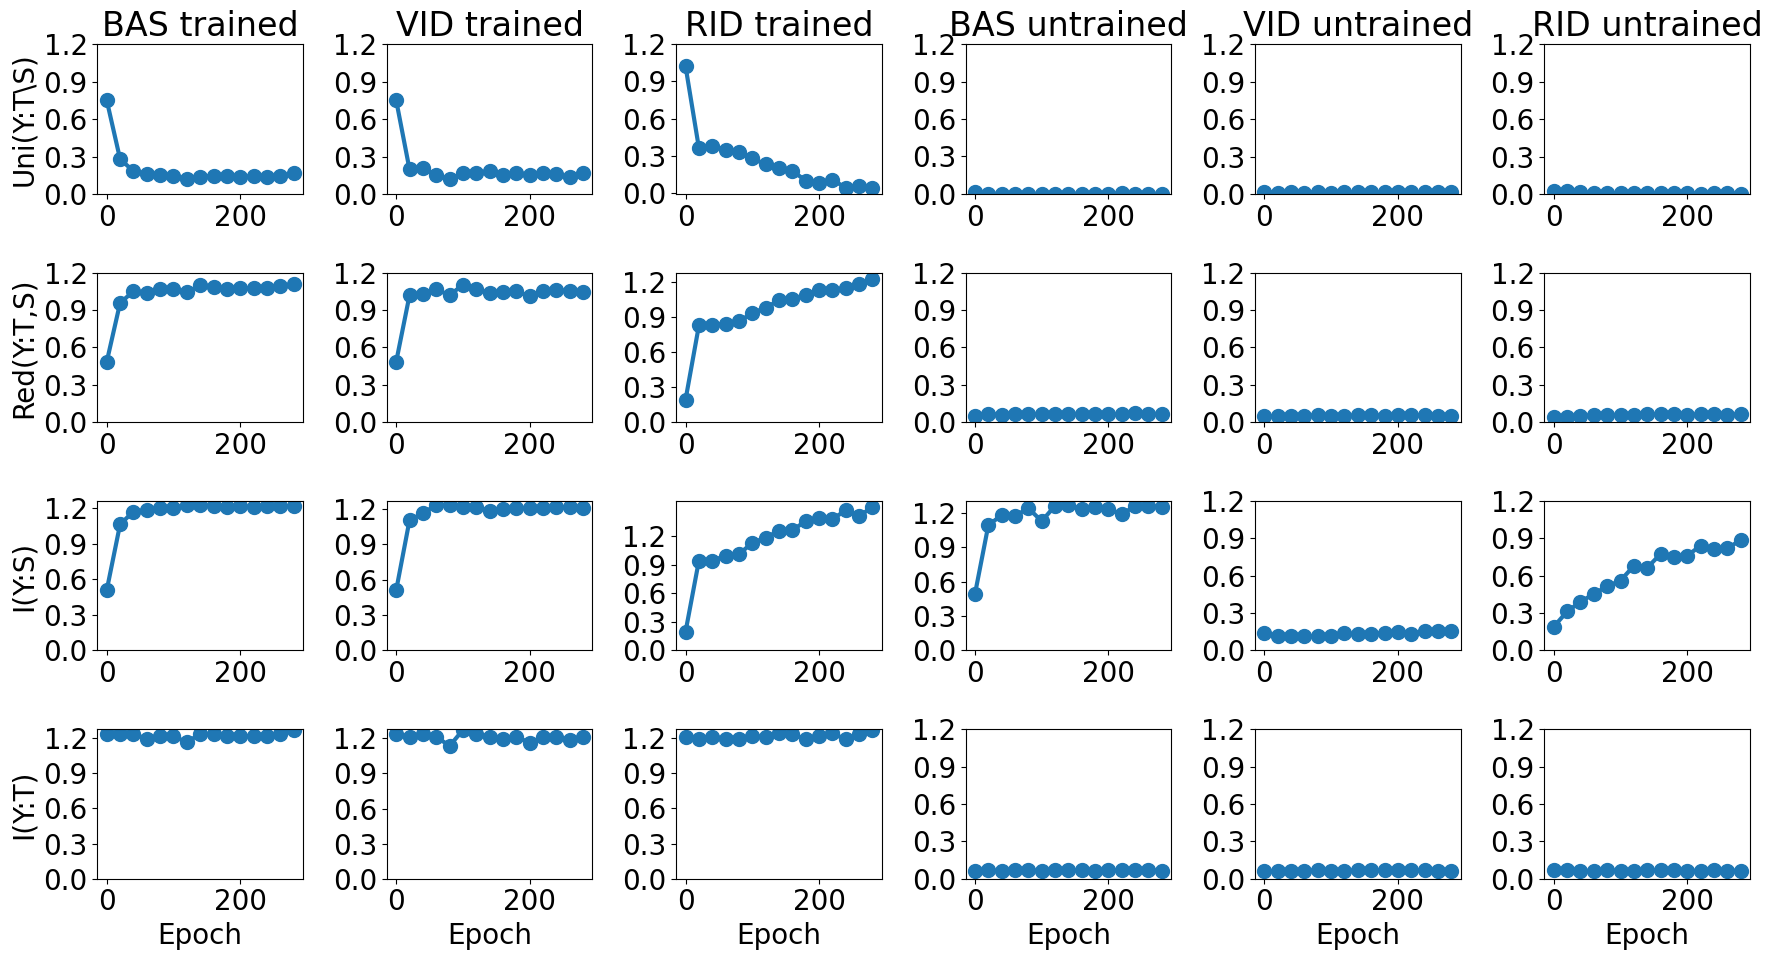

In [10]:
# Example list of folders (replace with your actual list)
folders = [
    './meas/meas_bas_tt', 
    './meas/meas_vid_tt', 
    './meas/meas_red_tt',
    # './meas/meas_ted_tt', 
    './meas/meas_bas_ut',
    './meas/meas_vid_ut', 
    './meas/meas_red_ut',
    # './meas/meas_ted_ut',
]
titles = [
    'BAS trained',
    'VID trained',
    'RID trained',
    # 'TED-trained-teacher',
    'BAS untrained',
    'VID untrained',
    'RID untrained',
    # 'TED-untrained-teacher',
]
n_reps = 3
# reps = range(n_reps)
reps = [2]

epochs = np.arange(0,300,20)


y_ticks = [
    np.linspace(0, 1.2, 5),
    np.linspace(0, 1.2, 5),
    np.linspace(0, 1.2, 5),
    np.linspace(0, 1.2, 5),
    np.linspace(0, 1.2, 5),
    np.linspace(0, 1.2, 5),
]

# Calculate the grid size
N = len(folders)
rows = 4
cols = N

# Create a grid of subplots
plt.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(rows, cols, figsize=(3*N, 10))
# axes = axes.flatten()  # Flatten the axes array to easily iterate over

for j, folder in enumerate(folders):
    syn = fetch_measures(folder, epochs, 'syn')
    uniT = fetch_measures(folder, epochs, 'uni1')
    uniS = fetch_measures(folder, epochs, 'uni2')
    red = fetch_measures(folder, epochs, 'red')
    miT = add_measures(uniT, red)
    miS = add_measures(uniS, red)
    measures_list = [uniT, red, miS, miT]
    measure_names = ['Uni(Y:T\S)', 'Red(Y:T,S)', 'I(Y:S)', 'I(Y:T)']
    for i in range(len(measures_list)):
        axes[i, 0].set_ylabel(measure_names[i])
        for rep_i in reps:
            axes[i, j].plot(epochs, measures_list[i][rep_i], '-o', label=rep_i, markersize=10, linewidth=3)
            axes[i, j].set_yticks(y_ticks[i])
            # axes[i, j].legend()

    axes[0, j].set_title(f"{titles[j]}")
    axes[rows-1, j].set_xlabel('Epoch')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()


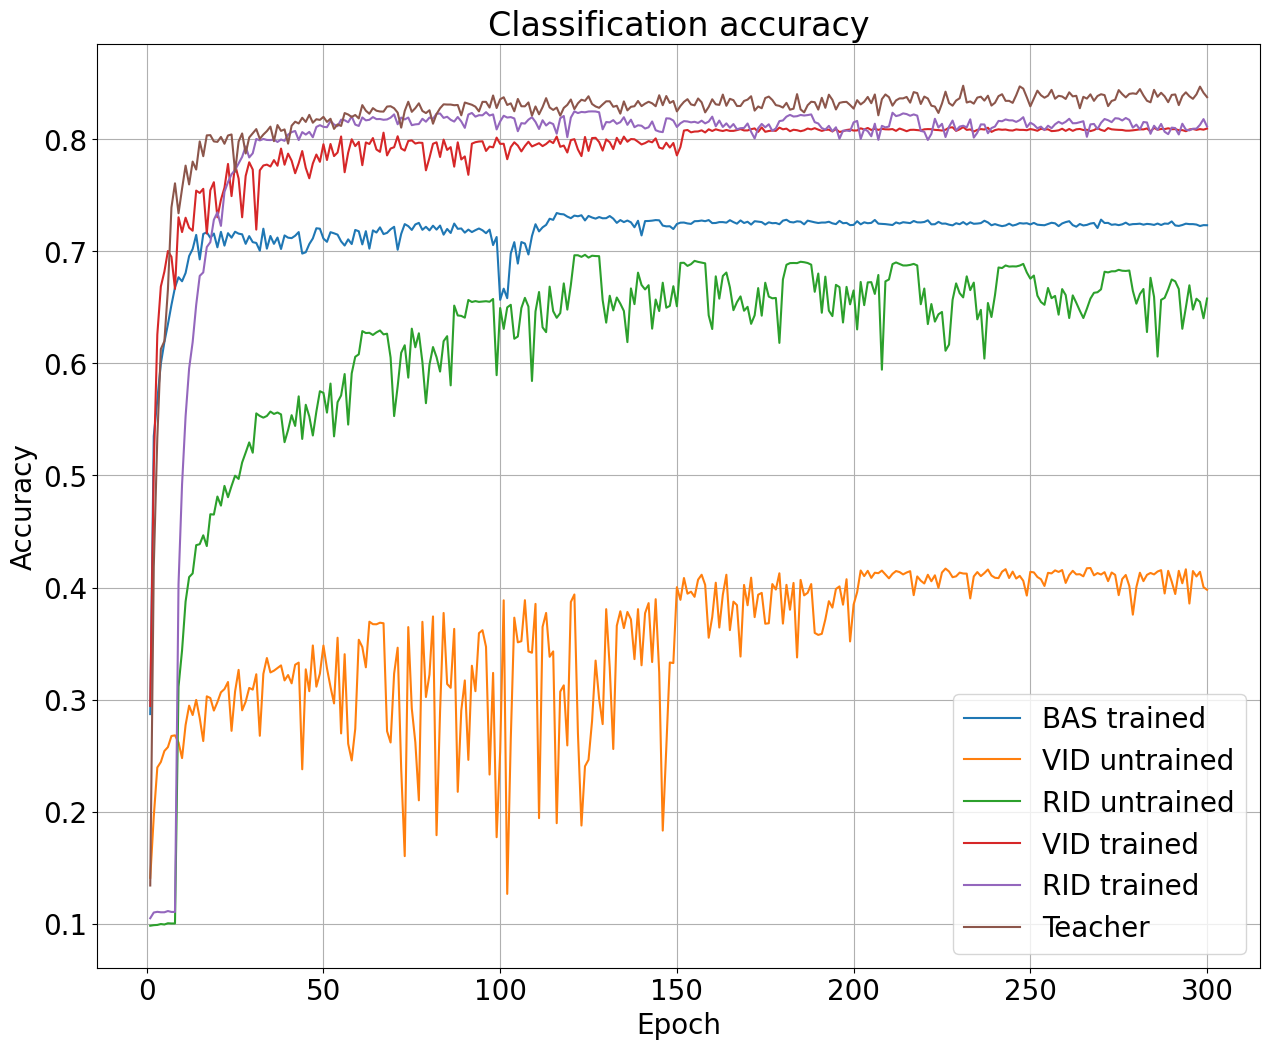

In [43]:
import pandas as pd

# Read the CSV file
df = pd.read_csv('exp4-accuracy.csv')

# Set the first column as the x-axis values
x = df.iloc[:, 0]

plt.figure(figsize=(15, 12))
labels = ['BAS trained', 'VID untrained', 'RID untrained', 'VID trained', 'RID trained', 'Teacher']
# Plot each subsequent column as a line
for i, column in enumerate(df.columns[1:]):
    plt.plot(x, df[column], label=labels[i])

# Customize the plot
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Classification accuracy')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()